In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/daily-website-visitors.csv')


In [2]:
data=data.drop(columns=['Row', 'Day','Date' ])


In [7]:
import numpy as np
data= data.values
data=np.asarray(data, dtype='float32')

In [9]:
data=pd.DataFrame(data)
data

,0,1,2,3,4
0,1.0,2146.0,1582.0,1430.0,152.0
1,2.0,3621.0,2528.0,2297.0,231.0
2,3.0,3698.0,2630.0,2352.0,278.0
3,4.0,3667.0,2614.0,2327.0,287.0
4,5.0,3316.0,2366.0,2130.0,236.0
...,...,...,...,...,...
2162,7.0,2221.0,1696.0,1373.0,323.0
2163,1.0,2724.0,2037.0,1686.0,351.0
2164,2.0,3456.0,2638.0,2181.0,457.0
2165,3.0,3581.0,2683.0,2184.0,499.0


In [19]:
data1=pd.DataFrame(X)
data1.corr()

,0,1,2,3,4
0,1.000000,-0.254273,-0.256338,-0.257842,0.381728
1,-0.254273,1.000000,0.988681,0.980702,0.638004
2,-0.256338,0.988681,1.000000,0.996169,0.630895
3,-0.257842,0.980702,0.996169,1.000000,0.596790
4,0.381728,0.638004,0.630895,0.596790,1.000000


In [17]:
data1 = data.drop(columns=['Day.Of.Week'])

In [11]:
y=data[4]
data=data.drop(columns=[4])
X=data.values

In [12]:
y=y.values

In [5]:
for i in range(1, 5):
    for j in range(len(data[data.columns[i]])):
        data[data.columns[i]][j] = float(data[data.columns[i]][j].replace(',', ''))
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
y=y.reshape(-1, 1)

In [14]:
import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

In [18]:
X

array([[2.000e+00, 3.621e+03, 2.528e+03, 2.297e+03, 1.520e+02],
       [3.000e+00, 3.698e+03, 2.630e+03, 2.352e+03, 2.310e+02],
       [4.000e+00, 3.667e+03, 2.614e+03, 2.327e+03, 2.780e+02],
       ...,
       [2.000e+00, 3.456e+03, 2.638e+03, 2.181e+03, 3.510e+02],
       [3.000e+00, 3.581e+03, 2.683e+03, 2.184e+03, 4.570e+02],
       [4.000e+00, 2.064e+03, 1.564e+03, 1.297e+03, 4.990e+02]],
      dtype=float32)

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

In [20]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [21]:
x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [24]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

In [25]:

#regression 
input_shape = x_train1.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)]

history=model.fit(
    x_train1,
    y_train1,
    validation_data=(x_test1, y_test1),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 1)        7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [36]:
callbacks = [keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
history=model.fit(
    x_train1,
    y_train1,
    validation_data=(x_test1, y_test1),
    epochs=2000,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/500
28/28 [==============================] - 1s 37ms/step - loss: 53.7270 - accuracy: 0.0000e+00 - val_loss: 21.7768 - val_accuracy: 0.0000e+00
Epoch 2/500
28/28 [==============================] - 1s 30ms/step - loss: 54.1076 - accuracy: 0.0000e+00 - val_loss: 27.5482 - val_accuracy: 0.0000e+00
Epoch 3/500
28/28 [==============================] - 1s 30ms/step - loss: 54.2000 - accuracy: 0.0000e+00 - val_loss: 12.3085 - val_accuracy: 0.0000e+00
Epoch 4/500
28/28 [==============================] - 1s 30ms/step - loss: 55.4275 - accuracy: 0.0000e+00 - val_loss: 7.5231 - val_accuracy: 0.0000e+00
Epoch 5/500
28/28 [==============================] - 1s 38ms/step - loss: 53.3229 - accuracy: 0.0000e+00 - val_loss: 10.3381 - val_accuracy: 0.0000e+00
Epoch 6/500
28/28 [==============================] - 1s 31ms/step - loss: 53.4052 - accuracy: 0.0000e+00 - val_loss: 7.7050 - val_accuracy: 0.0000e+00
Epoch 7/500
28/28 [==============================] - 1s 20ms/step - loss: 52.8495 - accura

In [49]:
#testing prediction
ypred=model.predict(x_test1)
#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))

mse:  42.951496
mae:  5.1870613
r2_score:  0.9973289402215032
explained_variance_score:  0.9973564147949219
max_error:  23.543945
mean_squared_log_error:  0.00024596046
mean_poisson_deviance:  0.9973289402215032
mean_gamma_deviance:  0.0002483536


In [50]:
#training prediction
xpred=model.predict(x_train1)
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  98.45845
mae:  7.5834804
r2_score:  0.9966582836553759
explained_variance_score:  0.9972653388977051
max_error:  58.303223
mean_squared_log_error:  0.00046922461
mean_poisson_deviance:  0.9966582836553759
mean_gamma_deviance:  0.00047671085


In [28]:
xx=[]
for i in range(len(pred)):
    xx.append(i)

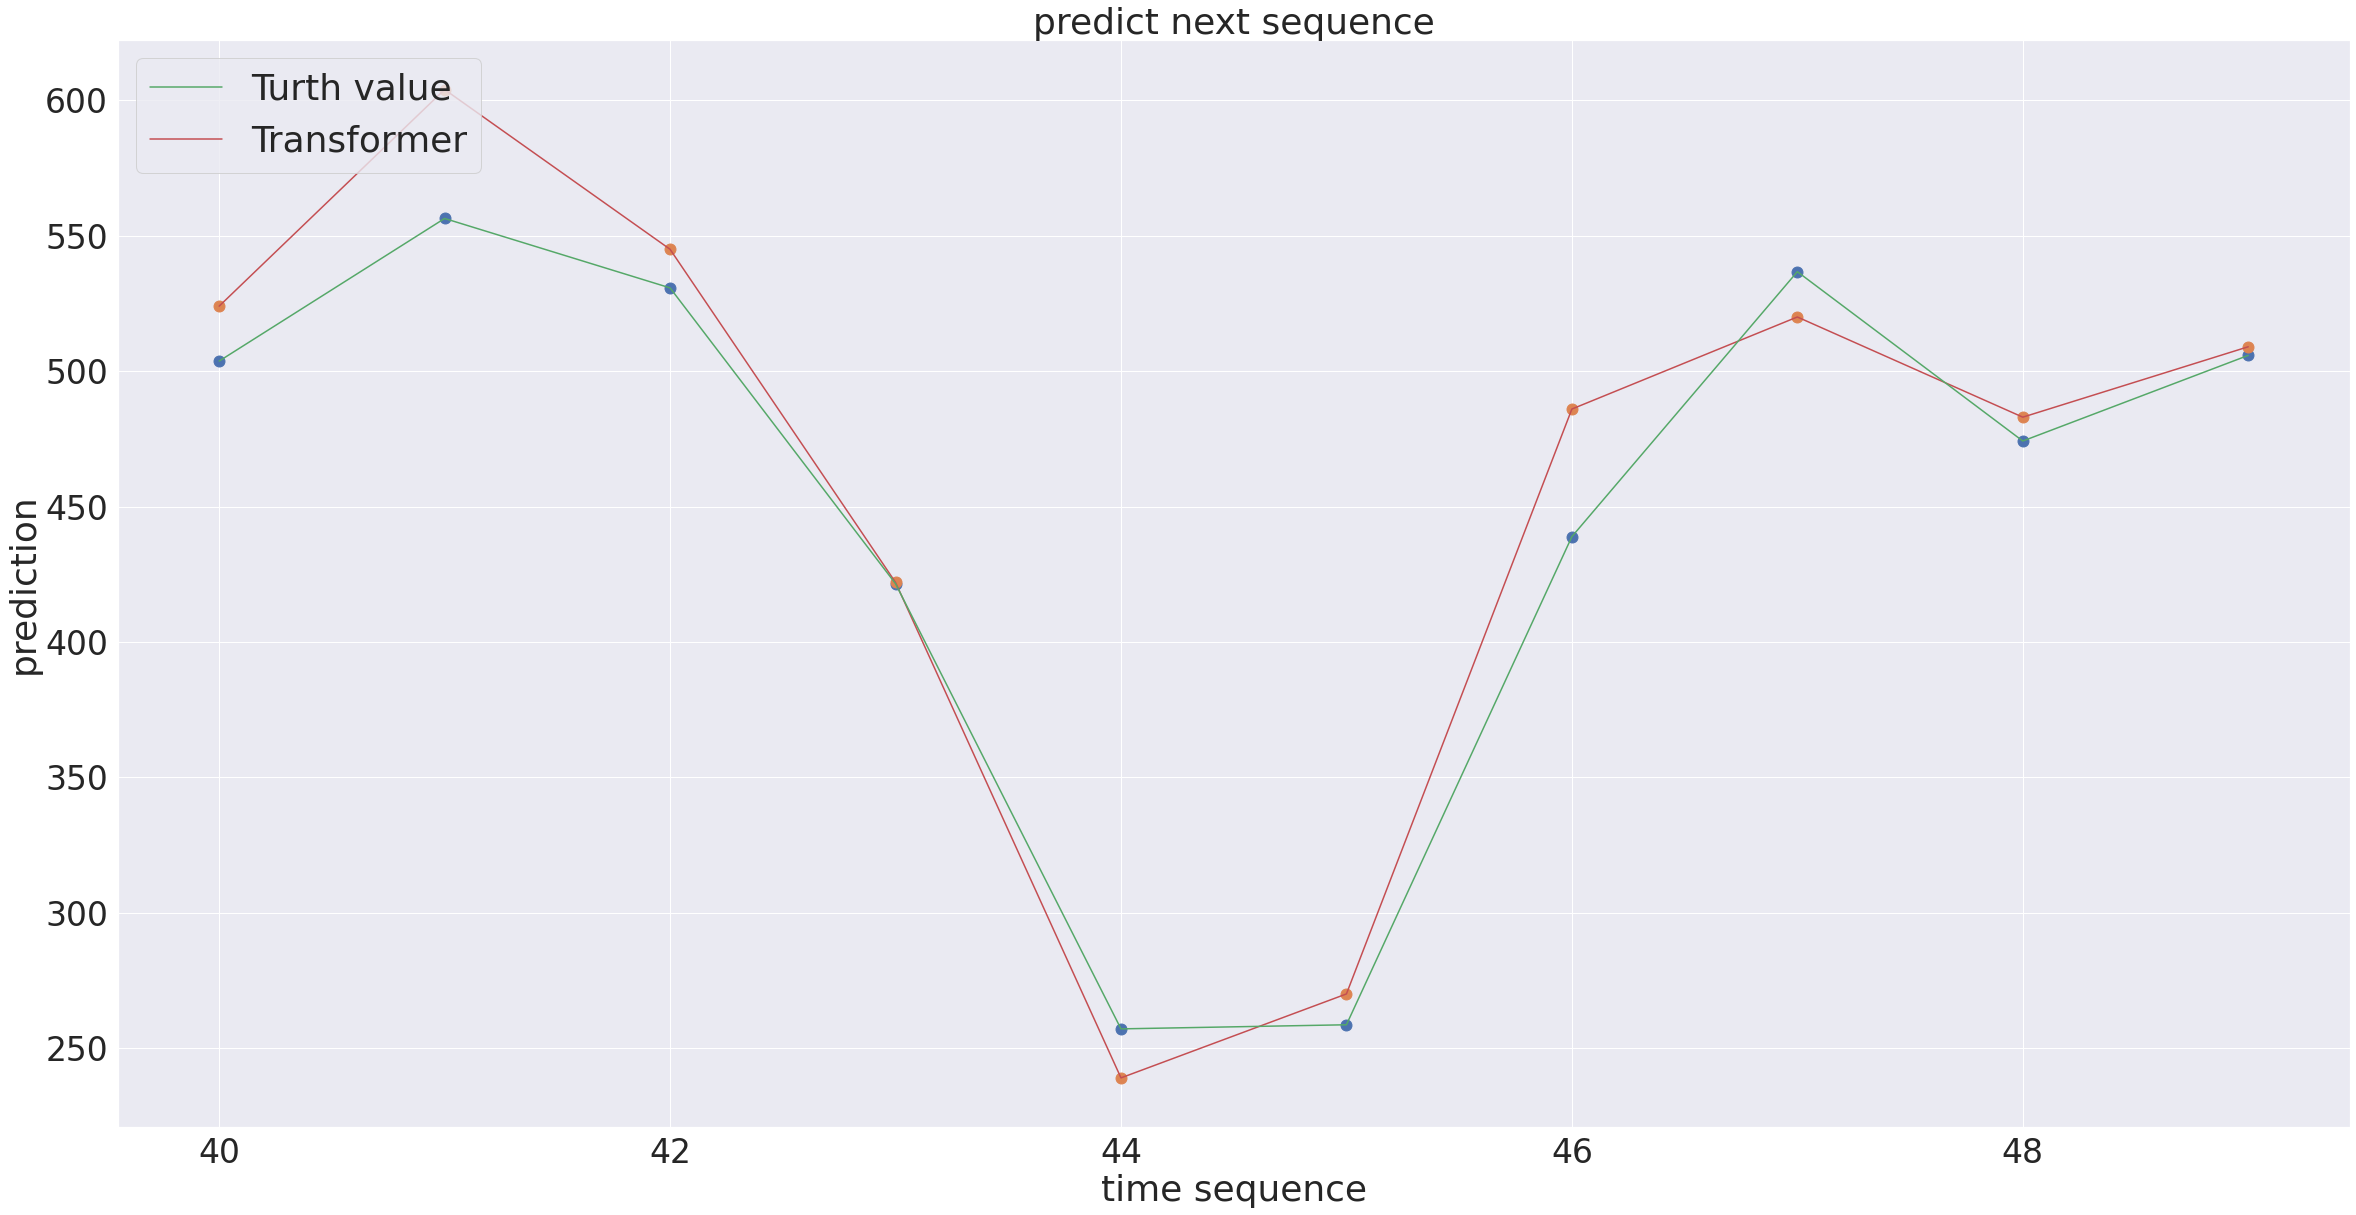

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=40
j=50
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],pred[i:j], color='g', label='Turth value', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Transformer')

plt.scatter(xx[i:j],pred[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('prediction', fontsize=36)
plt.show()

In [44]:
import pickle
with open('trans_y_predict.pickle', 'wb') as handle:
    pickle.dump(ypred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
import pickle
with open('trans_x_predict.pickle', 'wb') as handle:
    pickle.dump(xpred, handle, protocol=pickle.HIGHEST_PROTOCOL)